In [1]:
#@title Code - Load dependencies

#general
import io

# data
import numpy as np
import pandas as pd

# machine learning
import keras

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

chicago_taxi_dataset = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/chicago_taxi_train.csv")



In [6]:

#@title Code - Read dataset

# Updates dataframe to use specific columns.
training_df = chicago_taxi_dataset[['TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE']]

print('Read dataset completed successfully.')
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
print(training_df.head(200))


Read dataset completed successfully.
Total number of rows: 31694


     TRIP_MILES  TRIP_SECONDS   FARE                       COMPANY  \
0          2.57          2341  31.99                     Flash Cab   
1          1.18          1074   9.75                     Flash Cab   
2          1.29          1173  10.25                      Sun Taxi   
3          3.70          3360  23.75       Choice Taxi Association   
4          1.15          1044  10.00                     Flash Cab   
..          ...           ...    ...                           ...   
195        1.13           821   9.00  Blue Ribbon Taxi Association   
196        0.57           414   6.00                     Flash Cab   
197        1.22           886   9.00                  City Service   
198        1.68          1219   9.00                      Sun Taxi   
199        0.71           515   6.50                      Sun Taxi   

    PAYMENT_TYPE  TIP_RATE  
0         Mobile       6.3  
1    Credit Card      27.9  
2    

In [7]:

#@title Code - View dataset statistics

print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
print(training_df.describe(include='all'))


Total number of rows: 31694


          TRIP_MILES  TRIP_SECONDS          FARE    COMPANY PAYMENT_TYPE  \
count   31694.000000  31694.000000  31694.000000      31694        31694   
unique           NaN           NaN           NaN         31            7   
top              NaN           NaN           NaN  Flash Cab  Credit Card   
freq             NaN           NaN           NaN       7887        14142   
mean        8.289463   1319.796397     23.905210        NaN          NaN   
std         7.265672    928.932873     16.970022        NaN          NaN   
min         0.500000     60.000000      3.250000        NaN          NaN   
25%         1.720000    548.000000      9.000000        NaN          NaN   
50%         5.920000   1081.000000     18.750000        NaN          NaN   
75%        14.500000   1888.000000     38.750000        NaN          NaN   
max        68.120000   7140.000000    159.250000        NaN          NaN   

            TIP_RATE  
count   31694.000000  
unique     

In [4]:

#@title Code - View correlation matrix
print(training_df.corr(numeric_only = True))


              TRIP_MILES  TRIP_SECONDS      FARE  TIP_RATE
TRIP_MILES      1.000000      0.800855  0.975344 -0.049594
TRIP_SECONDS    0.800855      1.000000  0.830292 -0.084294
FARE            0.975344      0.830292  1.000000 -0.070979
TIP_RATE       -0.049594     -0.084294 -0.070979  1.000000


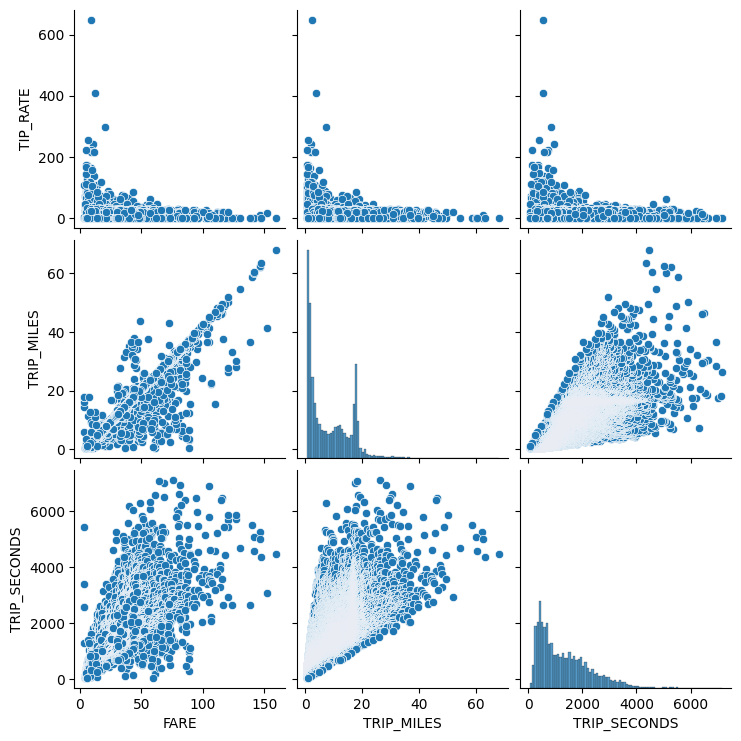

In [8]:

#@title Code - View pairplot
sns.pairplot(training_df, x_vars=["FARE", "TRIP_MILES", "TRIP_SECONDS"], y_vars=["TIP_RATE", "TRIP_MILES", "TRIP_SECONDS"])

In [1]:
#@title Define plotting functions

def make_plots(df, feature_names, label_name, model_output, sample_size=200):

  random_sample = df.sample(n=sample_size).copy()
  random_sample.reset_index()
  weights, bias, epochs, rmse = model_output

  is_2d_plot = len(feature_names) == 1
  model_plot_type = "scatter" if is_2d_plot else "surface"
  fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Loss Curve", "Model Plot"),
                      specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

  plot_data(random_sample, feature_names, label_name, fig)
  plot_model(random_sample, feature_names, weights, bias, fig)
  plot_loss_curve(epochs, rmse, fig)

  fig.show()
  return

def plot_loss_curve(epochs, rmse, fig):
  curve = px.line(x=epochs, y=rmse)
  curve.update_traces(line_color='#ff0000', line_width=3)

  fig.append_trace(curve.data[0], row=1, col=1)
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  fig.update_yaxes(title_text="Root Mean Squared Error", row=1, col=1, range=[rmse.min()*0.8, rmse.max()])

  return

def plot_data(df, features, label, fig):
  if len(features) == 1:
    scatter = px.scatter(df, x=features[0], y=label)
  else:
    scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)

  fig.append_trace(scatter.data[0], row=1, col=2)
  if len(features) == 1:
    fig.update_xaxes(title_text=features[0], row=1, col=2)
    fig.update_yaxes(title_text=label, row=1, col=2)
  else:
    fig.update_layout(scene1=dict(xaxis_title=features[0], yaxis_title=features[1], zaxis_title=label))

  return

def plot_model(df, features, weights, bias, fig):
  df['FARE_PREDICTED'] = bias[0]

  for index, feature in enumerate(features):
    df['FARE_PREDICTED'] = df['FARE_PREDICTED'] + weights[index][0] * df[feature]

  if len(features) == 1:
    model = px.line(df, x=features[0], y='FARE_PREDICTED')
    model.update_traces(line_color='#ff0000', line_width=3)
  else:
    z_name, y_name = "FARE_PREDICTED", features[1]
    z = [df[z_name].min(), (df[z_name].max() - df[z_name].min()) / 2, df[z_name].max()]
    y = [df[y_name].min(), (df[y_name].max() - df[y_name].min()) / 2, df[y_name].max()]
    x = []
    for i in range(len(y)):
      x.append((z[i] - weights[1][0] * y[i] - bias[0]) / weights[0][0])

    plane=pd.DataFrame({'x':x, 'y':y, 'z':[z] * 3})

    light_yellow = [[0, '#89CFF0'], [1, '#FFDB58']]
    model = go.Figure(data=go.Surface(x=plane['x'], y=plane['y'], z=plane['z'],
                                      colorscale=light_yellow))

  fig.add_trace(model.data[0], row=1, col=2)

  return

def model_info(feature_names, label_name, model_output):
  weights = model_output[0]
  bias = model_output[1]

  nl = "\n"
  header = "-" * 80
  banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

  info = ""
  equation = label_name + " = "

  for index, feature in enumerate(feature_names):
    info = info + "Weight for feature[{}]: {:.3f}\n".format(feature, weights[index][0])
    equation = equation + "{:.3f} * {} + ".format(weights[index][0], feature)

  info = info + "Bias: {:.3f}\n".format(bias[0])
  equation = equation + "{:.3f}\n".format(bias[0])

  return banner + nl + info + nl + equation

print("SUCCESS: defining plotting functions complete.")

SUCCESS: defining plotting functions complete.
